Welcome to my machine learning project! Here, I want to identify the genre of music from a given 30-second audio file. This is already a well-known problem in machine learning, so I wanted to go a step further and train several models to solve the problem. These models will go in order of increasing complexity. The first is K-Nearest Neighbors (KNN), Support Vector Machine (SVM), and Neural Network (NN).

### Importing Necessary Libraries

In [ ]:
import os
import librosa
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import IPython
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPool2D,Flatten,Dense,Dropout
from tensorflow.keras.optimizers.legacy import Adam

### Visualizing an Audio Sample

Here, identify the path to a sample file you want to visualize.

In [ ]:
sample_file = "drive/MyDrive/Fall 2024/CS 549/Class Project/archive/Data/genres_original/blues/blues.00000.wav"

This is the visualization for a raw waveform file. Not very useful on its own.

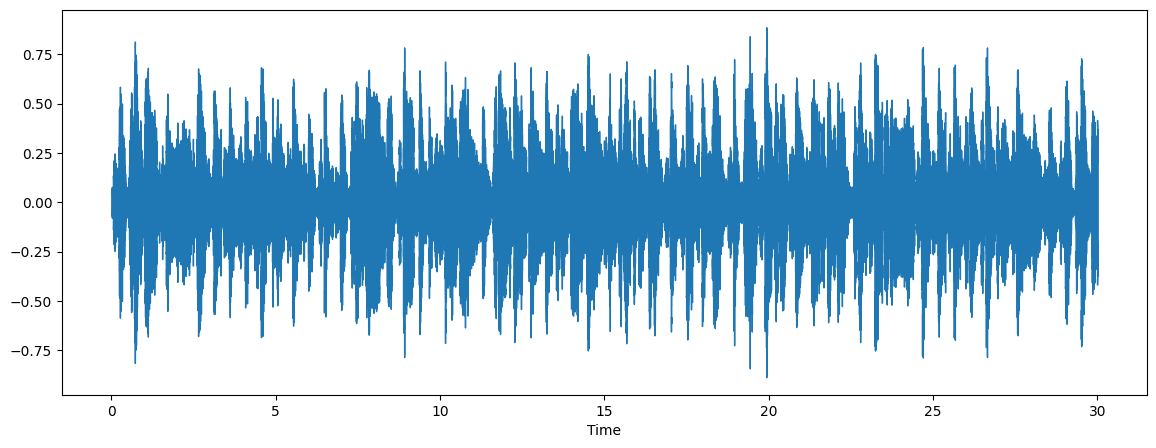

In [ ]:
y,sr = librosa.load(sample_file,sr=44100)
plt.figure(figsize=(14,5))
librosa.display.waveshow(y,sr=sr)

The spectrogram is a more useful visualization, plotting frequency over time.

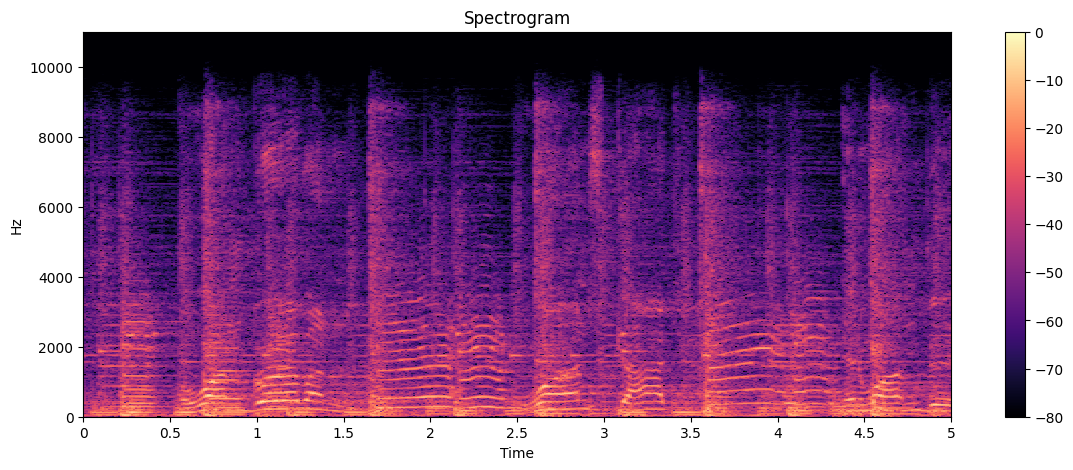

In [ ]:
# Generate the spectrogram
D = librosa.stft(y)  # Short-time Fourier transform
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

# Display the spectrogram
plt.figure(figsize=(14, 5))
librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()
plt.title('Spectrogram')
plt.xlim(0,5)   # display only the 1st 5 seconds
plt.ylim(0, 11000)
plt.show()

An even better visualization is the chromagram from the librosa library. Instead of raw frequencies, the y-axis shows labeled music notes.

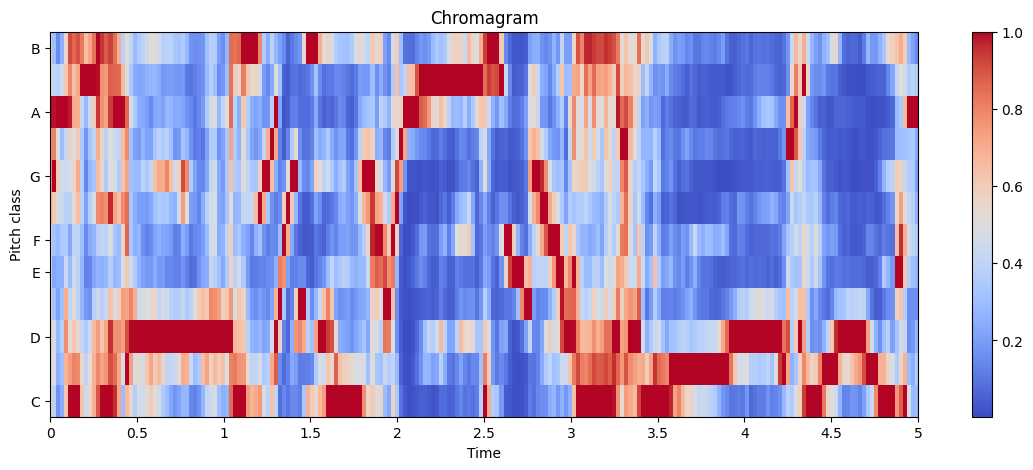

In [ ]:
# Generate the chromagram
chromagram = librosa.feature.chroma_stft(y=y, sr=sr)

# Display the chromagram
plt.figure(figsize=(14, 5))
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', cmap='coolwarm')
plt.colorbar()
plt.title('Chromagram')
plt.xlim(0, 5)   # display only the 1st 5 seconds
plt.show()

We can also listen to audio files using IPython.display.Audio.

In [ ]:
IPython.display.Audio(sample_file, rate=sr)

Now, the dataset I am using provides a csv file with the necessary numerical features for each audio file that we will be using to train the models.

In [ ]:
df = pd.read_csv("drive/MyDrive/Fall 2024/CS 549/Class Project/archive/Data/features_3_sec.csv")
df.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,blues.00000.1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,blues.00000.2.wav,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,blues.00000.3.wav,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,blues.00000.4.wav,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


### Preprocessing the Data

Since our classes are strings and not numeric values, we need to convert the strings to numeric values. We can use sklearn.preprocessing function LabelEncoder().

In [ ]:
classes = df.iloc[:,-1]     # column of labels
encoder = LabelEncoder()
y = encoder.fit_transform(classes)

We need to normalize the data to prevent any skewing based on the magnitude of the values. We can do this by subtracting the mean and dividing by the standard deviation.

In [ ]:
scale = StandardScaler()
X = scale.fit_transform(np.array(df.iloc[:,1:-1], dtype=float))

Now the data must be split into training and testing. We will use 10% of the data for testing, and the rest for training.

We want to further split the training data into training and validation data. We will use 30% of the training subset for validation.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.3)

Now, it is time to train our models.

### K-Nearest Neighbors (KNN)

This is the simplest model that we will use. K-Nearest Neighbors simply has the $k$ closest data points to a test point vote on what the test point's label should be.

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5)  # You can adjust the number of neighbors
knn.fit(X_train, y_train)
knn.score(X_valid, y_valid)

0.8676797627872498

We see with $k=5$ the accuracy is about 87%, which is not bad. But let's play around with many values of $k$ to determine the best one.

Text(0.5, 0, 'K')

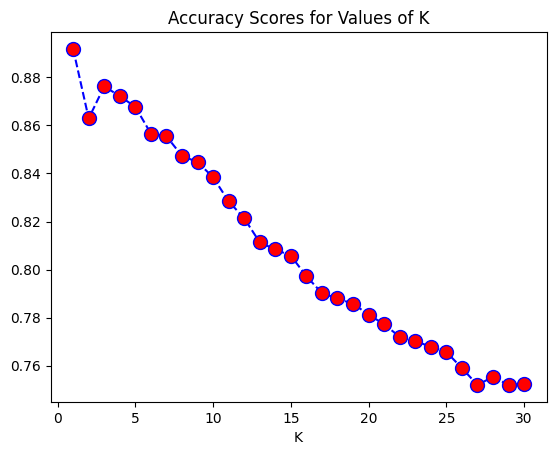

In [ ]:
scores = []
for k in range(1, 31):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    scores.append(knn.score(X_valid, y_valid))

plt.plot(range(1, 31), scores, color='blue', linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)
plt.title('Accuracy Scores for Values of K')
plt.xlabel('K')

In [ ]:
print(f"k = {np.argmax(scores)+1}")
print(max(scores))

k = 1
0.8917716827279466


We can see that with $k=1$ we get the best accuracy of around 90%, then as $k$ increases the accuracy decreases.

### Multiclass Support Vector Machine (SVM)

This is the next model we will test, which is more complex than the previous.

In [ ]:
svm = SVC(kernel='linear', C=1)
svm.fit(X_train, y_train)
svm.score(X_valid, y_valid)

0.7390659747961453

We can see that with a linear kernel and $C=1$, we get about 76% accuracy. We will test with different kernels and $C$ values to see which combination produces the best results.

In [ ]:
# Warning: this code chunk may take several minutes to run.

scores_lin = []     # track scores for each kernel
scores_poly = []
scores_rbf = []
scores_sig = []
for C in range(1, 31, 3):   # train svm with each kernel and many C values
    svm_lin = SVC(kernel='linear', C=C)
    svm_lin.fit(X_train, y_train)
    scores_lin.append(svm_lin.score(X_valid, y_valid))
    svm_poly = SVC(kernel='poly', C=C)
    svm_poly.fit(X_train, y_train)
    scores_poly.append(svm_poly.score(X_valid, y_valid))
    svm_rbf = SVC(kernel='rbf', C=C)
    svm_rbf.fit(X_train, y_train)
    scores_rbf.append(svm_rbf.score(X_valid, y_valid))
    svm_sig = SVC(kernel='sigmoid', C=C)
    svm_sig.fit(X_train, y_train)
    scores_sig.append(svm_sig.score(X_valid, y_valid))

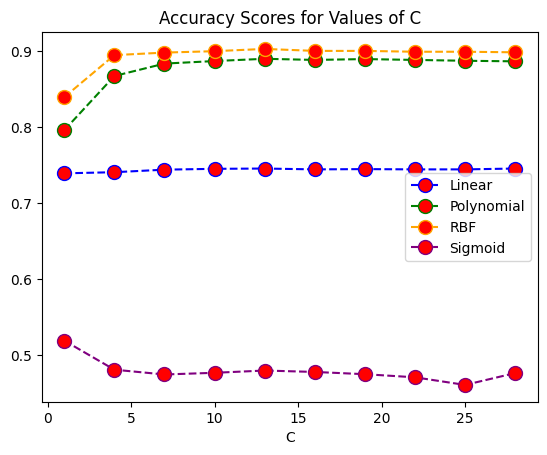

In [ ]:
# plot the scores for each kernel as C varies
plt.plot(range(1, 31, 3), scores_lin, color='blue', linestyle='dashed', marker='o', markerfacecolor='red', markersize=10, label='Linear')
plt.plot(range(1, 31, 3), scores_poly, color='green', linestyle='dashed', marker='o', markerfacecolor='red', markersize=10, label='Polynomial')
plt.plot(range(1, 31, 3), scores_rbf, color='orange', linestyle='dashed', marker='o', markerfacecolor='red', markersize=10, label='RBF')
plt.plot(range(1, 31, 3), scores_sig, color='purple', linestyle='dashed', marker='o', markerfacecolor='red', markersize=10, label='Sigmoid')
plt.legend()
plt.title('Accuracy Scores for Values of C')
plt.xlabel('C')
plt.show()

In [ ]:
print("Best scores for each kernel:")
print("Linear:", max(scores_lin))
print("Polynomial:", max(scores_poly))
print("RBF:", max(scores_rbf))
print("Sigmoid:", max(scores_sig))

Best scores for each kernel:
Linear: 0.7453669384729429
Polynomial: 0.8895478131949592
RBF: 0.902520385470719
Sigmoid: 0.5192735359525574


In [ ]:
print("Best C value for each kernel:")
print("Linear:", np.argmax(scores_lin)*3+1)
print("Polynomial:", np.argmax(scores_poly)*3+1)
print("RBF:", np.argmax(scores_rbf)*3+1)
print("Sigmoid:", np.argmax(scores_sig)*3+1)

Best C value for each kernel:
Linear: 13
Polynomial: 13
RBF: 13
Sigmoid: 1


We can see that the SVM performed the best with the RBF kernel and $C=13$, with a score of almost 91%, just edging out KNN.

### Neural Network (NN)

This is the most complex model out of the ones we will be testing. There are many different hyperparameters to test, and thoroughly testing all combinations would be very inefficient. To save time, I will use the Relu activation function for the input and hidden layers, and the softmax activation function for the output layer. I will also be using the Adam optimizer. Additionally, the number of neurons in each hidden layer will be half as many as in the previous, and they will all be powers of 2.

What I will be testing is different number of layers and different dropout values. To save time for testing purposes, I will use 50 epochs per combination, and once I find the best combination, I will then test it with more epochs.

In [ ]:
def trainNN(X_train, y_train, X_valid, y_valid, num_layers, dropout, epochs):
    model = Sequential()
    for i in range(num_layers):
        if i == 0:
            model.add(Dense(int(2**(5+num_layers)), activation='relu', input_shape=(X_train.shape[1],)))
        else:
            model.add(Dense(int(2**(5+num_layers-i)), activation='relu'))
        model.add(Dropout(dropout))
    model.add(Dense(10, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=epochs)
    return model, history

In [ ]:
def plot_history(history):
    print("Validation Accuracy: ", max(history.history["val_accuracy"]))
    plt.plot(history.history['accuracy'], label='training')
    plt.plot(history.history['val_accuracy'], label = 'validation')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Epochs')
    plt.show()

First, let's test different dropout values of 0, 0.2, and 0.5.

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


197/197 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.4468 - loss: 1.5087 - val_accuracy: 0.6753 - val_loss: 0.9175
Epoch 2/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7532 - loss: 0.7083 - val_accuracy: 0.7795 - val_loss: 0.6581
Epoch 3/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.8337 - loss: 0.4797 - val_accuracy: 0.8147 - val_loss: 0.5546
Epoch 4/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8821 - loss: 0.3577 - val_accuracy: 0.8191 - val_loss: 0.5254
Epoch 5/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9088 - loss: 0.2678 - val_accuracy: 0.8436 - val_loss: 0.4547
Epoch 6/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9281 - loss: 0.2028 - val_accuracy: 0.8603 - val_loss: 0.4456
Epoch 7/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9460 - loss: 0.1620 - val_accuracy: 0.8651 - val_loss: 0.4503
Epoch 8/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9588 - loss: 0.1235 - val_accuracy: 0.8614 - va

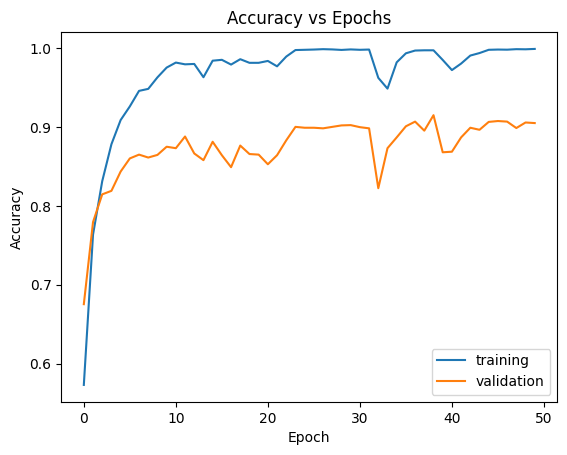

In [ ]:
model, history = trainNN(X_train, y_train, X_valid, y_valid, 4, 0, 50)
plot_history(history)

Epoch 1/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.3509 - loss: 1.7672 - val_accuracy: 0.6842 - val_loss: 0.9368
Epoch 2/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.6584 - loss: 1.0146 - val_accuracy: 0.7487 - val_loss: 0.7456
Epoch 3/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.7254 - loss: 0.8242 - val_accuracy: 0.7546 - val_loss: 0.7094
Epoch 4/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.7719 - loss: 0.6906 - val_accuracy: 0.7958 - val_loss: 0.6181
Epoch 5/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8059 - loss: 0.5847 - val_accuracy: 0.8069 - val_loss: 0.5522
Epoch 6/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8249 - loss: 0.5265 - val_accuracy: 0.8217 - val_loss: 0.5423
Epoch 7/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8522 - loss: 0.4619 - val_accuracy: 0.8410 - val_loss: 0.4867
Epoch 8/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8682 - loss: 0.3956 - val_accur

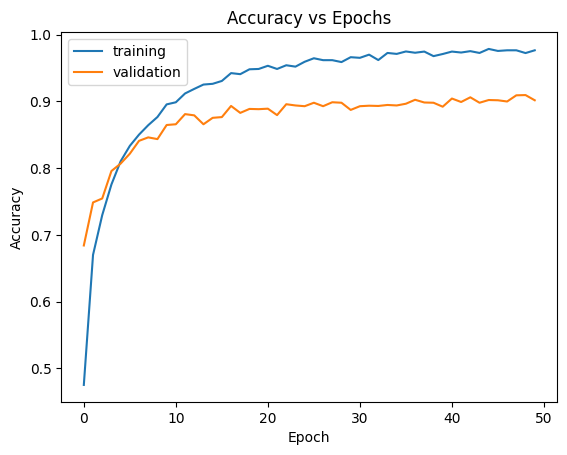

In [ ]:
model, history = trainNN(X_train, y_train, X_valid, y_valid, 4, 0.2, 50)
plot_history(history)

Epoch 1/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.1724 - loss: 2.2589 - val_accuracy: 0.4418 - val_loss: 1.5955
Epoch 2/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.3855 - loss: 1.6938 - val_accuracy: 0.5604 - val_loss: 1.3030
Epoch 3/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.4505 - loss: 1.5351 - val_accuracy: 0.6212 - val_loss: 1.1543
Epoch 4/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5235 - loss: 1.3741 - val_accuracy: 0.6464 - val_loss: 1.0393
Epoch 5/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5594 - loss: 1.2762 - val_accuracy: 0.6916 - val_loss: 0.9549
Epoch 6/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5946 - loss: 1.1673 - val_accuracy: 0.7053 - val_loss: 0.8867
Epoch 7/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6161 - loss: 1.1257 - val_accuracy: 0.7209 - val_loss: 0.8276
Epoch 8/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6517 - loss: 1.0241 - val_accuracy: 

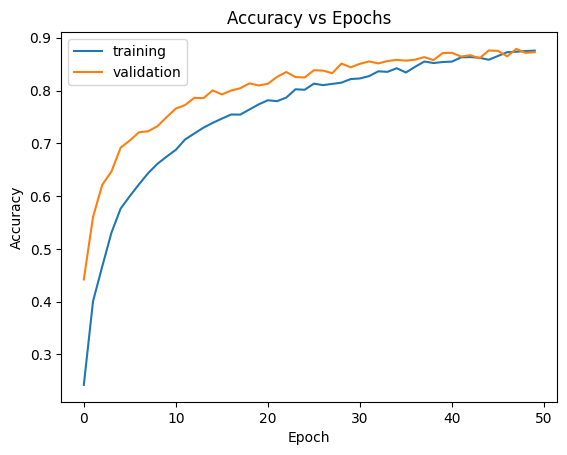

In [ ]:
model, history = trainNN(X_train, y_train, X_valid, y_valid, 4, 0.5, 50)
plot_history(history)

From this, we can see that a dropout value of 0.2 is a good option, since it has consistent results and reduces overfitting while still having a high validation result. Next, let's test number of layers.

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3515 - loss: 1.8234 - val_accuracy: 0.6160 - val_loss: 1.1097
Epoch 2/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5883 - loss: 1.1550 - val_accuracy: 0.6790 - val_loss: 0.9159
Epoch 3/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6497 - loss: 0.9758 - val_accuracy: 0.7102 - val_loss: 0.8164
Epoch 4/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6815 - loss: 0.9172 - val_accuracy: 0.7443 - val_loss: 0.7435
Epoch 5/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7240 - loss: 0.7953 - val_accuracy: 0.7569 - val_loss: 0.6940
Epoch 6/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7372 - loss: 0.7563 - val_accuracy: 0.7746 - val_loss: 0.6597
Epoch 7/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7552 - loss: 0.6946 - val_accuracy: 0.7798 - val_loss: 0.6295
Epoch 8/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7624 - loss: 0.6828 - val_accuracy: 0.7906 - val_

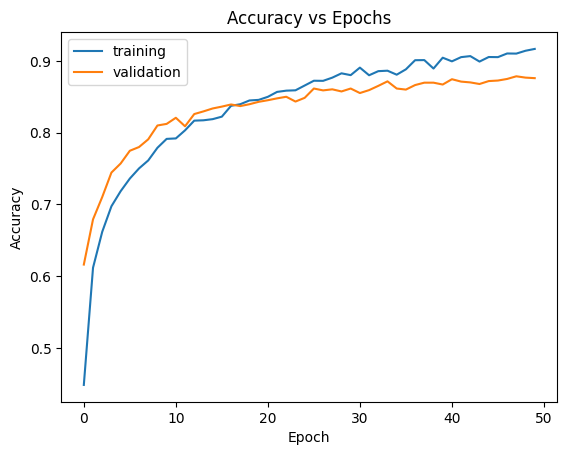

In [ ]:
model, history = trainNN(X_train, y_train, X_valid, y_valid, 2, 0.2, 50)
plot_history(history)

Epoch 1/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.3673 - loss: 1.7652 - val_accuracy: 0.6479 - val_loss: 1.0392
Epoch 2/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6307 - loss: 1.0878 - val_accuracy: 0.7131 - val_loss: 0.8274
Epoch 3/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6936 - loss: 0.8799 - val_accuracy: 0.7643 - val_loss: 0.7027
Epoch 4/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7283 - loss: 0.8014 - val_accuracy: 0.7724 - val_loss: 0.6638
Epoch 5/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7612 - loss: 0.7076 - val_accuracy: 0.8017 - val_loss: 0.5990
Epoch 6/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7717 - loss: 0.6540 - val_accuracy: 0.8054 - val_loss: 0.5760
Epoch 7/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8108 - loss: 0.5610 - val_accuracy: 0.8136 - val_loss: 0.5407
Epoch 8/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8112 - loss: 0.5476 - val_accuracy: 0.

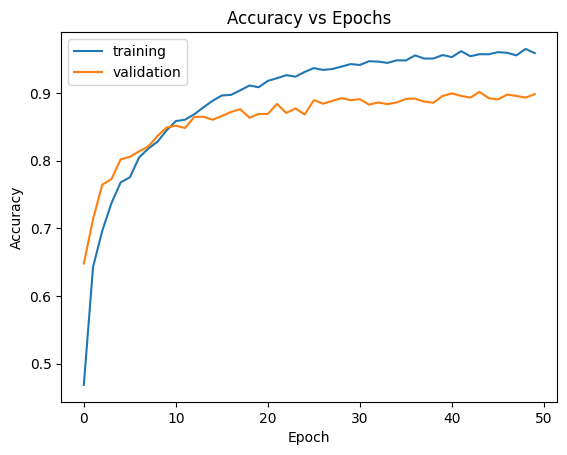

In [ ]:
model, history = trainNN(X_train, y_train, X_valid, y_valid, 3, 0.2, 50)
plot_history(history)

Epoch 1/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.3569 - loss: 1.7693 - val_accuracy: 0.6531 - val_loss: 0.9936
Epoch 2/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.6533 - loss: 1.0293 - val_accuracy: 0.7350 - val_loss: 0.8004
Epoch 3/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.7362 - loss: 0.7839 - val_accuracy: 0.7806 - val_loss: 0.6655
Epoch 4/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.7895 - loss: 0.6614 - val_accuracy: 0.7913 - val_loss: 0.6122
Epoch 5/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.8117 - loss: 0.5747 - val_accuracy: 0.8021 - val_loss: 0.5937
Epoch 6/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.8428 - loss: 0.4705 - val_accuracy: 0.8121 - val_loss: 0.5906
Epoch 7/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.8599 - loss: 0.4297 - val_accuracy: 0.8395 - val_loss: 0.4951
Epoch 8/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.8787 - loss: 0.3694 - val_accu

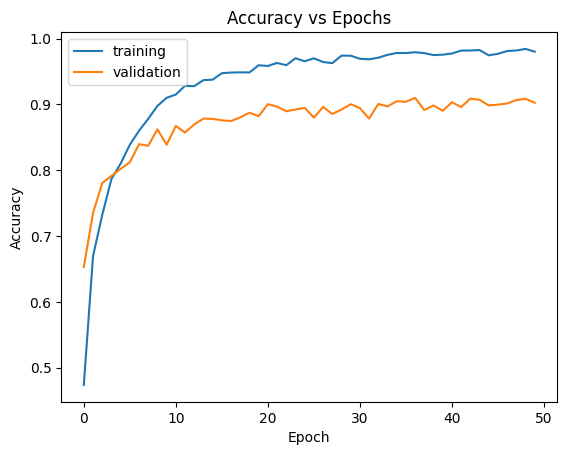

In [ ]:
model, history = trainNN(X_train, y_train, X_valid, y_valid, 5, 0.2, 50)
plot_history(history)

We can see that the model gets incrementally better as we add more layers, but the runtime and computations get significantly bigger. For the sake of time we will use 4 layers. Now with good hyperparameters, let's try training the model with many more epochs.

Epoch 1/500


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


197/197 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.3707 - loss: 1.7397 - val_accuracy: 0.6468 - val_loss: 0.9839
Epoch 2/500
197/197 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.6434 - loss: 1.0237 - val_accuracy: 0.7216 - val_loss: 0.7857
Epoch 3/500
197/197 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.7318 - loss: 0.8009 - val_accuracy: 0.7635 - val_loss: 0.6917
Epoch 4/500
197/197 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.7677 - loss: 0.6934 - val_accuracy: 0.8017 - val_loss: 0.5957
Epoch 5/500
197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7966 - loss: 0.5923 - val_accuracy: 0.7898 - val_loss: 0.6058
Epoch 6/500
197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8286 - loss: 0.5107 - val_accuracy: 0.8232 - val_loss: 0.5411
Epoch 7/500
197/197 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8446 - loss: 0.4673 - val_accuracy: 0.8188 - val_loss: 0.5637
Epoch 8/500
197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8577 - loss: 0.4299 - val_accuracy: 0.8

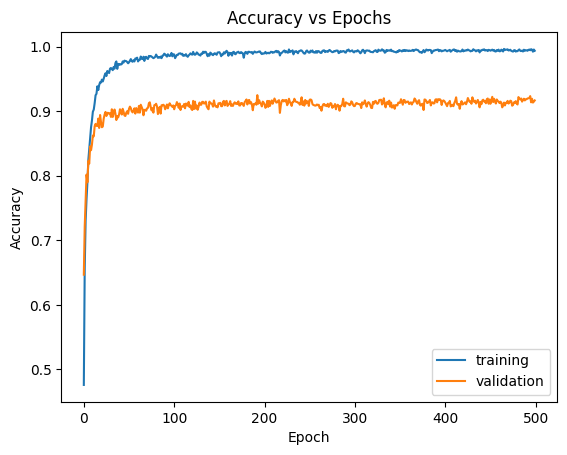

In [ ]:
# Warning: this code chunk may take several minutes to run.

nn, history = trainNN(X_train, y_train, X_valid, y_valid, 4, 0.2, 500)
plot_history(history)

### Evaluation

In [ ]:
def plot_confusion_matrix(y_test, y_pred, model):
    cm = confusion_matrix(y_test, y_pred)

    # Decode labels
    decoded_labels = encoder.inverse_transform(np.unique(y_test))

    # Create DataFrame
    cm_df = pd.DataFrame(cm, index=decoded_labels, columns=decoded_labels)

    # Create the heatmap using seaborn
    plt.figure(figsize=(10, 8))  # Adjust figure size as needed
    sns.heatmap(cm_df, annot=True, cmap='viridis', fmt='g') # annot=True displays numbers, fmt='g' formats as general
    plt.title(f'Heatmap of {model} Confusion Matrix')
    plt.show()

Now that we have trained each model and found the best hyperparameters for them, it is time to see how they do with the actual test data.

KNN:

In [ ]:
y_pred_knn = knn.predict(X_test)

# Classification Report (includes precision and recall)
print(classification_report(encoder.inverse_transform(y_test), encoder.inverse_transform(y_pred_knn)))

              precision    recall  f1-score   support

       blues       0.89      0.74      0.81       115
   classical       0.82      0.94      0.88        83
     country       0.74      0.76      0.75       101
       disco       0.58      0.79      0.67        99
      hiphop       0.79      0.70      0.74        90
        jazz       0.75      0.79      0.77        96
       metal       0.81      0.84      0.82       104
         pop       0.91      0.78      0.84        94
      reggae       0.77      0.71      0.74       117
        rock       0.66      0.61      0.64       100

    accuracy                           0.76       999
   macro avg       0.77      0.77      0.76       999
weighted avg       0.77      0.76      0.76       999



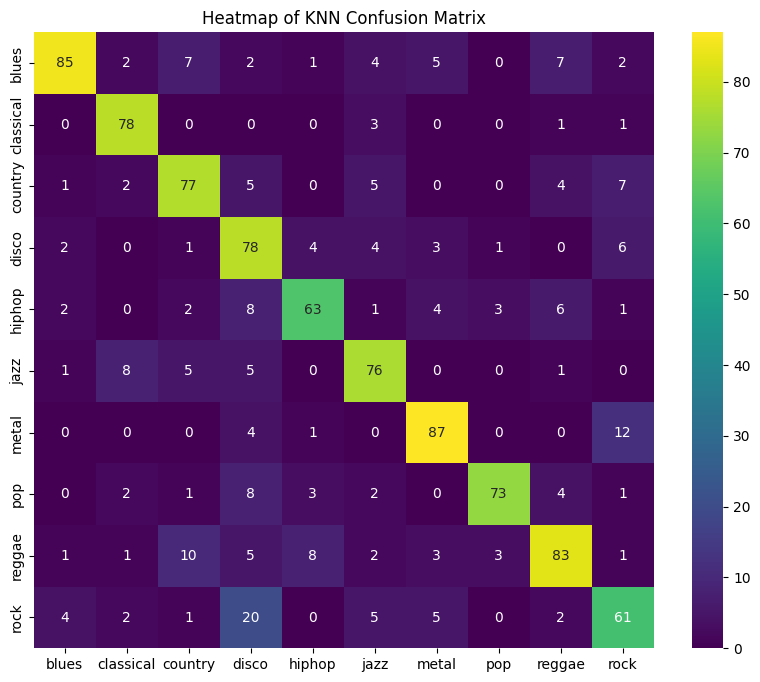

In [ ]:
plot_confusion_matrix(y_test, y_pred_knn, "KNN")

KNN had an overall accuracy of 0.76, performing the best with classical (F1 score of 0.85) and performing the worst with rock and disco (F1 score of 0.67).

SVM:

In [ ]:
svm = SVC(kernel='rbf', C=13)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

# Classification Report (includes precision and recall)
print(classification_report(encoder.inverse_transform(y_test), encoder.inverse_transform(y_pred_svm)))

              precision    recall  f1-score   support

       blues       0.94      0.94      0.94       115
   classical       0.89      0.95      0.92        83
     country       0.92      0.90      0.91       101
       disco       0.86      0.91      0.88        99
      hiphop       0.92      0.92      0.92        90
        jazz       0.83      0.93      0.88        96
       metal       0.94      0.97      0.96       104
         pop       0.97      0.90      0.93        94
      reggae       0.97      0.91      0.94       117
        rock       0.93      0.84      0.88       100

    accuracy                           0.92       999
   macro avg       0.92      0.92      0.92       999
weighted avg       0.92      0.92      0.92       999



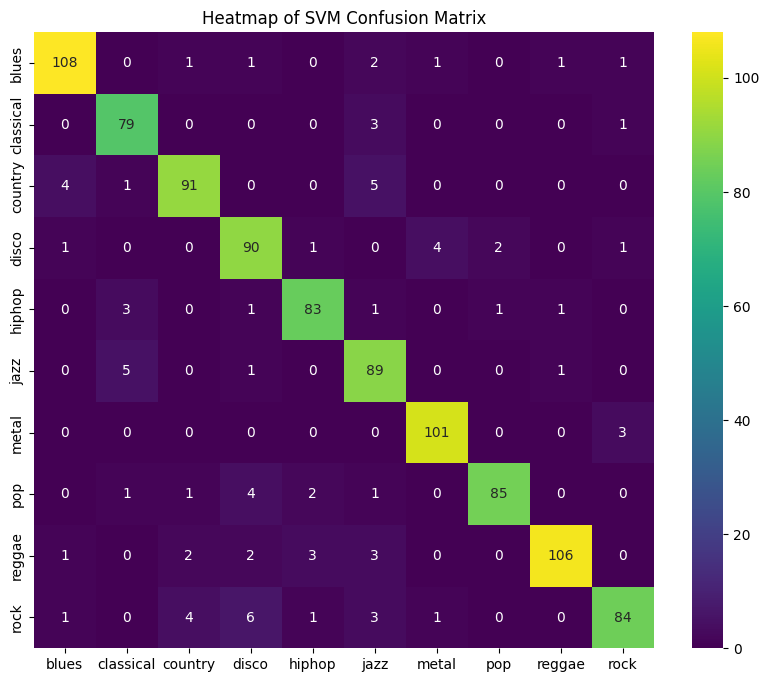

In [ ]:
plot_confusion_matrix(y_test, y_pred_svm, "SVM")

SVM ended up performing much better than KNN, with an overall accuracy of 0.90. It performed the best with reggae (F1 score of 0.94) and the worst with rock (F1 score of 0.83).

NN:

In [ ]:
y_pred_nn = nn.predict(X_test)
y_pred_nn = np.argmax(y_pred_nn, axis=1)

# Classification Report (includes precision and recall)
print(classification_report(encoder.inverse_transform(y_test), encoder.inverse_transform(y_pred_nn)))

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
              precision    recall  f1-score   support

       blues       0.96      0.92      0.94       115
   classical       0.92      0.96      0.94        83
     country       0.88      0.90      0.89       101
       disco       0.88      0.91      0.90        99
      hiphop       0.96      0.90      0.93        90
        jazz       0.88      0.96      0.92        96
       metal       0.89      0.97      0.93       104
         pop       0.99      0.94      0.96        94
      reggae       0.98      0.94      0.96       117
        rock       0.91      0.85      0.88       100

    accuracy                           0.92       999
   macro avg       0.93      0.93      0.92       999
weighted avg       0.93      0.92      0.93       999



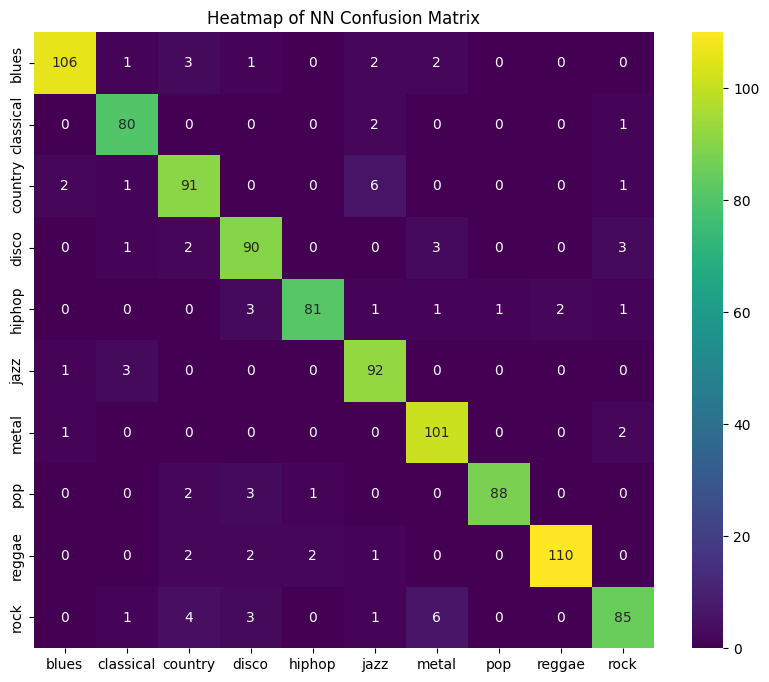

In [ ]:
plot_confusion_matrix(y_test, y_pred_nn, "NN")

NN performed about the same as SVM with an accuracy of 0.92. It performed best with pop and reggae (F1 score of 0.96) and performed worst with rock (F1 score of 0.88).